# Recall/MABO as a function of number of proposals included

In [15]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
from utils import calculate_iou


def get_ss_proposals(image_name : str):
    # Extract predicted boxes
    with open(os.path.join('Potholes', 'annotated-images', image_name + '_ss.json')) as f:
        pred_boxes = json.load(f)
    
    # Extract bounding box coordinates
    pred_boxes = [pred_box['bbox'] for pred_box in pred_boxes]
    
    #shuffle
    np.random.shuffle(pred_boxes)
    
    return pred_boxes
    

def bounding_box_recall_and_mabo(max_proposals, thresholds = np.array([0.7]), proposal_getter = get_ss_proposals):
    #n_proposals_range: list of integers, x-ticks for plot
    #threshold: float in [0,1], IOU threshold for a correct detection
    #proposal_getter: function that takes an image name such as 'img-1' and returns a list of bounding boxes in [xmin, ymin, xmax, ymax] format
    
    # Use only training data
    with open(os.path.join('Potholes', 'splits.json')) as f:
        splits = json.load(f)
    
    xml_names = splits['train']
    
    # Strip .xml
    image_names = [xml_name[:-4] for xml_name in xml_names]
    
    recalls = np.zeros((max_proposals, len(thresholds)))
    mabos = np.zeros(max_proposals)    
    images_with_this_many_proposals = np.zeros(max_proposals)
    
    # Loop through images
    for image_name in image_names:
        # Extract ground truth
        tree = ET.parse(os.path.join('Potholes', 'annotated-images', image_name + '.xml'))
        root = tree.getroot()
        GT_boxes = [
            [int(box.find("bndbox/xmin").text), 
             int(box.find("bndbox/ymin").text), 
             int(box.find("bndbox/xmax").text), 
             int(box.find("bndbox/ymax").text)]
            for box in root.iter('object')
        ]
        
        pred_boxes = proposal_getter(image_name)[:max_proposals]
    

        # Count number of images with at least a certain number of proposals
        images_with_this_many_proposals[:len(pred_boxes)] += 1
        
        
        # Precompute IOUs for all GT and predicted boxes
        iou_matrix = np.array([[calculate_iou(gt_box, pred_box) for pred_box in pred_boxes] for gt_box in GT_boxes])
        
        cummax_ious = np.maximum.accumulate(iou_matrix, axis=1)
        recalls_this_image = np.zeros((max_proposals, len(thresholds)))
       
        recalls_this_image[:len(pred_boxes)] = np.mean(cummax_ious[:, :, None] > thresholds, axis=0)    
        recalls_this_image[len(pred_boxes):] = recalls_this_image[len(pred_boxes)-1]
        
        mabos_this_image = np.zeros(max_proposals)
        mabos_this_image[:len(pred_boxes)] = np.mean(cummax_ious, axis=0)
        mabos_this_image[len(pred_boxes):] = mabos_this_image[len(pred_boxes)-1]
        
        recalls += recalls_this_image
        mabos += mabos_this_image
            
        
    
    mean_recalls = recalls / len(image_names)
    mean_mabos = mabos / len(image_names)
    fraction_of_images = images_with_this_many_proposals / len(image_names)
    
    return mean_recalls, mean_mabos, fraction_of_images

In [16]:
# Example usage
thresholds = np.array([0.5, 0.7])
recall, mabo, fraction_of_images = bounding_box_recall_and_mabo(3000, thresholds=thresholds)

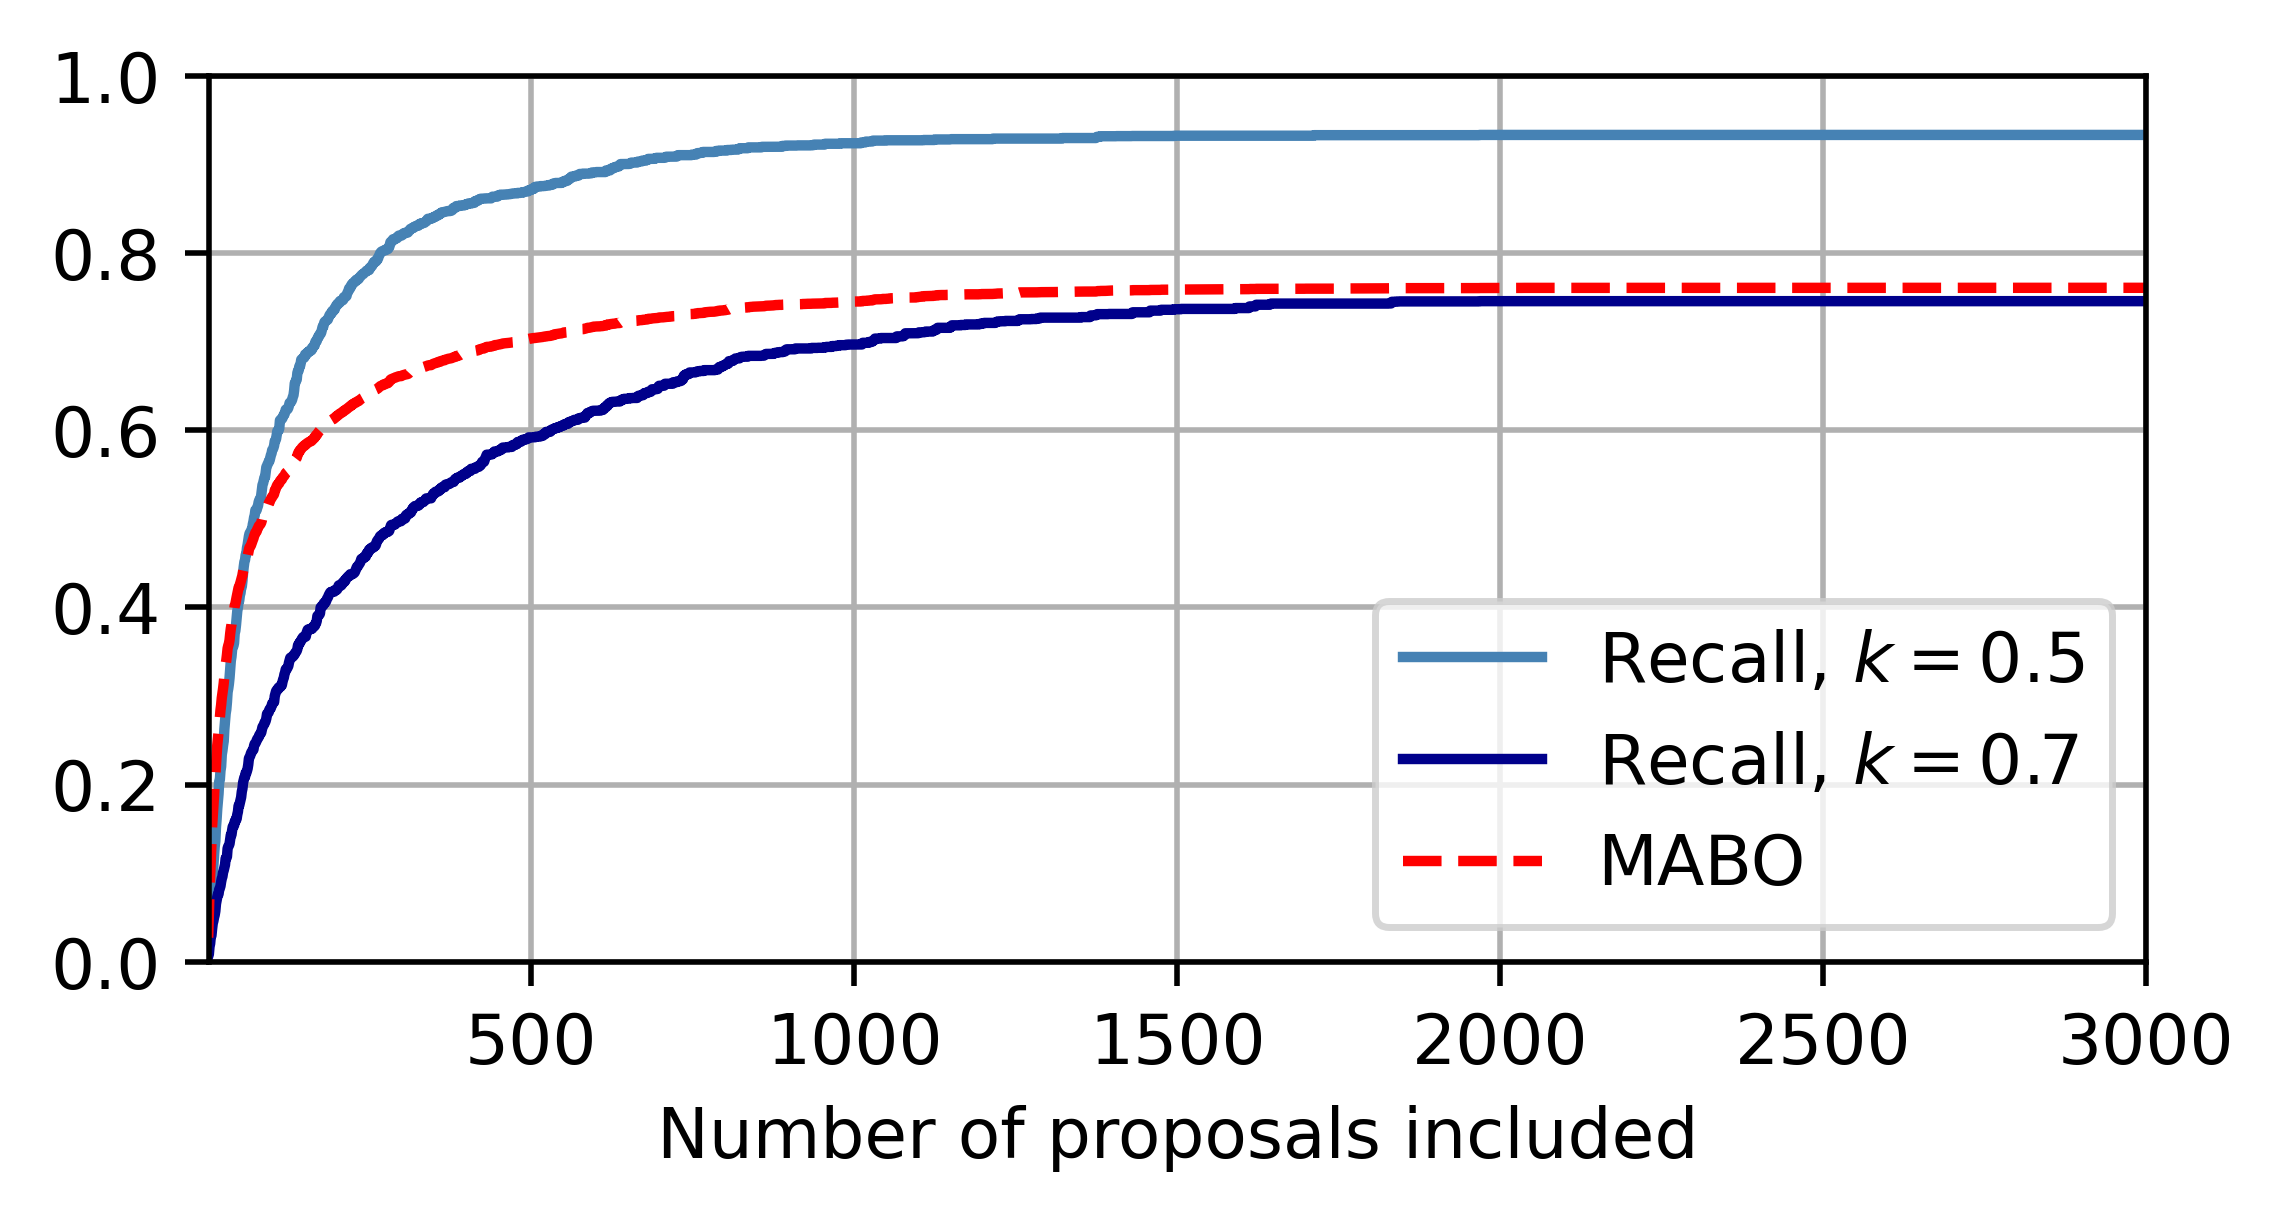

In [8]:
plt.rc('text', usetex=False)
#plt.rc('font', family='serif')

plt.figure(figsize=(5, 2.3), dpi=500)


#two blue colors
colors = ['#4682B4', 'darkblue']  # Light blue and dark blue

for threshold, recall_curve, color in zip(thresholds, recall.T, colors):
    plt.plot(recall_curve, label=f'Recall, $k = {threshold}$', color = color)
    
plt.plot(mabo,  '--', label='MABO', color = 'red')
#plt.plot(fraction_of_images, '--', color = 'gray', alpha = 0.3, label='Fraction of images')

plt.grid(True)
plt.xlabel('Number of proposals included')
#plt.title('Evaluation of required number of proposals')
plt.ylim(0, 1)
plt.xlim(1, 3000)

#plt.vlines(1500, 0, 1, color='black', linestyle='--')

# make yaxis percentages
#plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])

plt.legend()
plt.show()

# Verify that 'compute_t' and 'alter_box' works as expected

In [10]:
from utils import compute_t, alter_box

In [6]:
test_true_box = [0, 0, 100, 100]
test_prop_box = [5, 10, 110, 120]

t = compute_t(test_true_box, test_prop_box)
print(t)
alter_box(test_prop_box, t)



(-0.047619047619047616, -0.09090909090909091, -0.048790164169432056, -0.0953101798043249)


(0.0, 0.0, 100.0, 100.0)

# Edge boxes

In [17]:
from module.proposal_generators.edge_boxes import return_edge_box_proposals
from module.proposal_generators.store_all import store_all_proposals

In [18]:
#takes about 14 minutes to run on my machine (Ø)
#store_all_proposals(return_edge_box_proposals, 'eb', max_boxes=3000, min_score=0.01, Canny_lower_threshold=50, Canny_upper_threshold=150)

In [19]:
def get_eb_proposals(image_name : str):
    
    # Extract predicted boxes
    with open(os.path.join('Potholes', 'annotated-images', image_name + '_eb.json')) as f:
        pred_boxes = json.load(f)
    
    # Extract bounding box coordinates
    pred_boxes = [pred_box['bbox'] for pred_box in pred_boxes]
    
    #shuffle
    np.random.shuffle(pred_boxes)
    
    return pred_boxes

In [20]:
import numpy as np
max_proposals = 3000
recall_EB, mabo_EB, fraction_of_images_EB = bounding_box_recall_and_mabo(max_proposals, proposal_getter=get_eb_proposals, thresholds=thresholds)

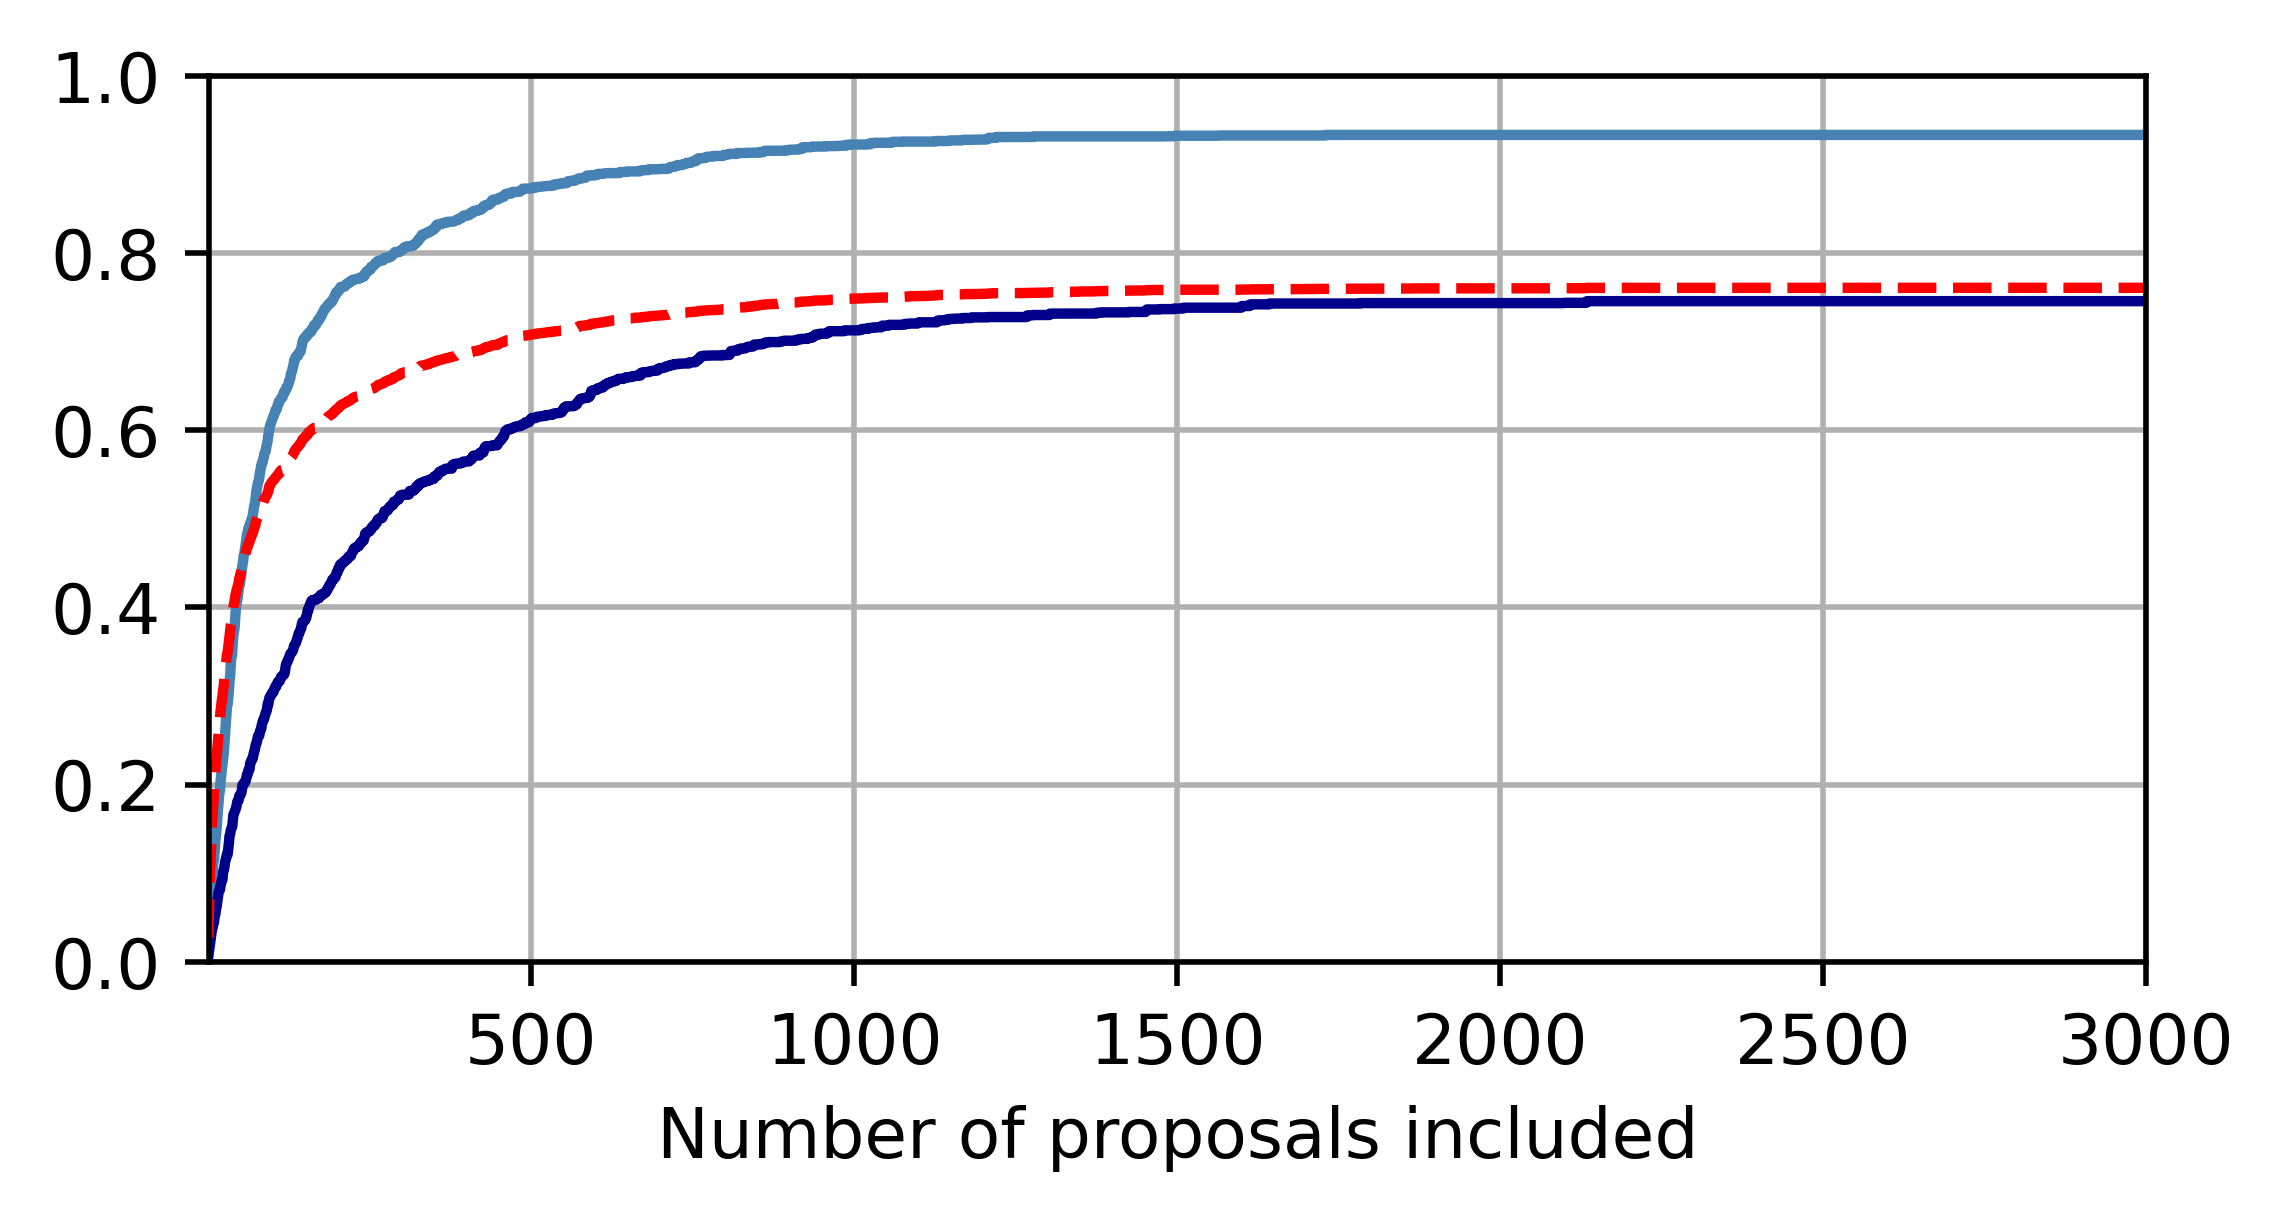

In [21]:
plt.rc('text', usetex=False)
#plt.rc('font', family='serif')

plt.figure(figsize=(5, 2.3), dpi=500)


#two blue colors
colors = ['#4682B4', 'darkblue']  # Light blue and dark blue

for threshold, recall_curve, color in zip(thresholds, recall.T, colors):
    plt.plot(recall_curve, label=f'Recall, $k = {threshold}$', color = color)
    
plt.plot(mabo,  '--', label='MABO', color = 'red')
#plt.plot(fraction_of_images, '--', color = 'gray', alpha = 0.3, label='Fraction of images')

plt.grid(True)
plt.xlabel('Number of proposals included')
#plt.title('Evaluation of required number of proposals')
plt.ylim(0, 1)
plt.xlim(1, 3000)

#plt.vlines(1500, 0, 1, color='black', linestyle='--')

# make yaxis percentages
#plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])

#plt.legend()
plt.show()

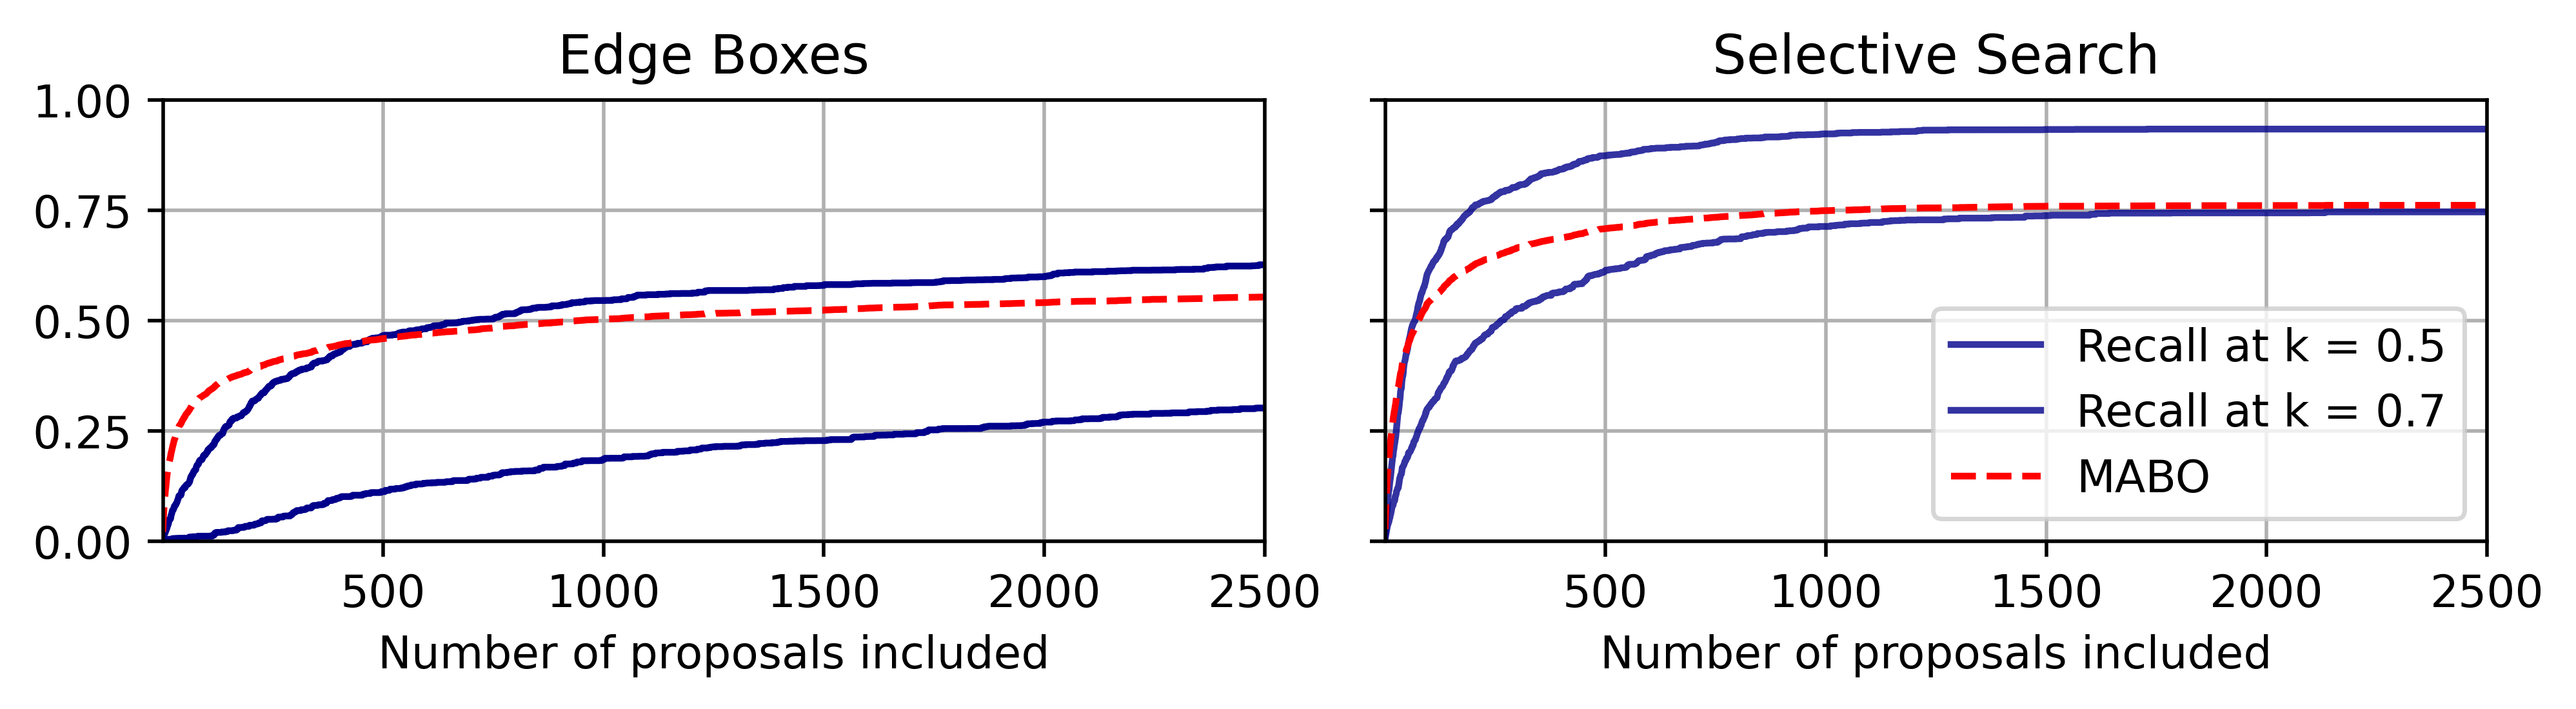

In [29]:
def plot_recall_mabo(recall_list, mabo_list, titles, thresholds = thresholds):
    n = len(recall_list)
    
    fig, ax = plt.subplots(1, n, figsize=(4*n, 2.3), dpi=500, facecolor='none', edgecolor='none')
    
    for i in range(n):
        recall = recall_list[i]
        mabo = mabo_list[i]
        
        
        
        ax[i].plot(recall, label=[f'Recall at k = {k}' for k in thresholds], color = 'darkblue', alpha = 1-0.2*i)
        ax[i].plot(mabo, '--', label='MABO', color = 'red')
        
        ax[i].grid(True)
        ax[i].set_xlabel('Number of proposals included')
        
        ax[i].set_ylim(0, 1)
        ax[i].set_xlim(1, 2500)
        ax[i].set_title(titles[i])
        
    ax[1].legend()
    
    #shared y-axis
    ax[1].set_yticklabels([])
    
    fig.tight_layout()
    plt.show()
    
plot_recall_mabo([recall_EB, recall], [mabo_EB, mabo], titles=['Edge Boxes', 'Selective Search'])    
    

# Non maximum supression

In [2]:
from module.processing.non_maximum_suppression import non_maximum_suppression

In [9]:
import numpy as np
from utils import calculate_iou
test_boxes = [
    [0, 0, 100, 100],
    [0, 0, 110, 110],
    [0, 0, 120, 120],
    [115, 115, 125, 125],
    ]

pairwise_iou = np.array([[calculate_iou(box1, box2) for box2 in test_boxes] for box1 in test_boxes])
print(pairwise_iou)


ps = [0.8, 0.9, 0.5, 0.2]

non_maximum_suppression(list(zip(test_boxes, ps)), 0.84)
# when looking at the most likely box (box 2), box 3 will be discarded because iou(box2, box3) = 0.8403 > 0.84
# Then we will inspect box 1, and nothing will be discarded.
# Then we will inspect box 4, and nothing will be discarded.

# So the output should be [box2, box1, box4] with corresponding probabilities [0.9, 0.8, 0.2]

[[1.         0.82644628 0.69444444 0.        ]
 [0.82644628 1.         0.84027778 0.        ]
 [0.69444444 0.84027778 1.         0.00172712]
 [0.         0.         0.00172712 1.        ]]


[([0, 0, 110, 110], 0.9), ([0, 0, 100, 100], 0.8), ([115, 115, 125, 125], 0.2)]

# Visualize some edge boxes and SS boxes

Number of GT boxes: 2
Number of SS proposals: 745
Number of EB proposals: 3000


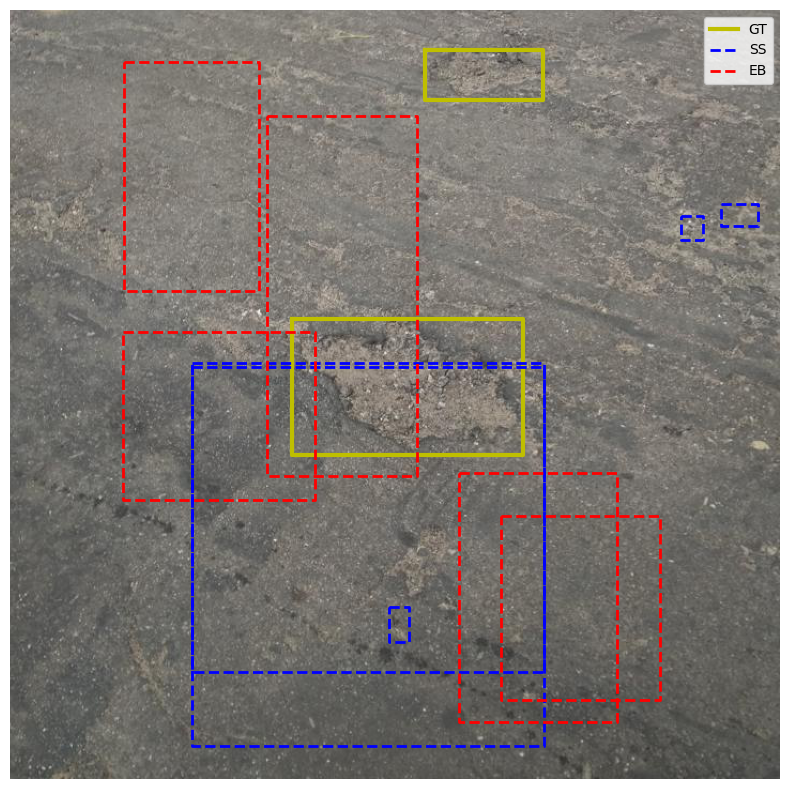

In [56]:
from utils import parse_xml
import os
import random

img = 'img-9'

with open(os.path.join('Potholes', 'annotated-images', img + '.xml')) as f:
    GT_boxes = parse_xml(f)

print(f'Number of GT boxes: {len(GT_boxes)}')

SS_boxes = get_ss_proposals(img)
EB_boxes = get_eb_proposals(img)
print(f'Number of SS proposals: {len(SS_boxes)}')
print(f'Number of EB proposals: {len(EB_boxes)}')

image = plt.imread(os.path.join('Potholes', 'annotated-images', img + '.jpg'))

#show image
plt.figure(figsize=(10, 10))
plt.imshow(image)


# Plot GT boxes
for box in GT_boxes:
    plt.plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], 'y', linewidth=3, label='GT')

# Plot SS boxes
for box in random.sample(SS_boxes, 5):
    plt.plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], 'b--', linewidth=2, label='SS')

# Plot EB boxes
for box in random.sample(EB_boxes, 5):
    plt.plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], 'r--', linewidth=2, label='EB')

# Remove duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.axis('off')

plt.show()

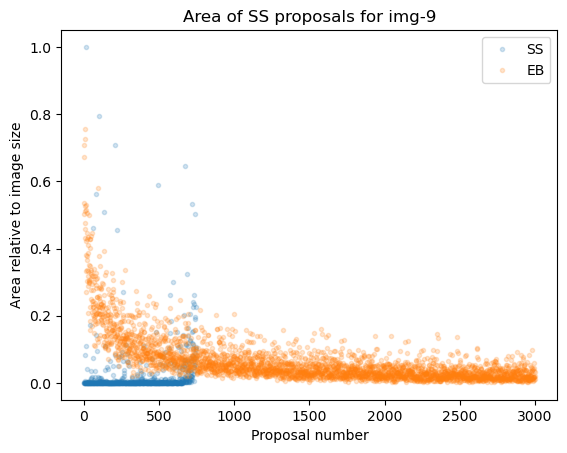

In [48]:
def Area(box, width, height):
    return (box[2] - box[0])/width * (box[3] - box[1])/height

ss_areas = [Area(box, *image.shape[:2]) for box in SS_boxes]
eb_areas = [Area(box, *image.shape[:2]) for box in EB_boxes]

plt.plot(ss_areas, '.', label = 'SS', alpha = 0.2)
plt.plot(eb_areas, '.', label = 'EB', alpha = 0.2)
plt.xlabel('Proposal number')
plt.ylabel('Area relative to image size')
plt.title(f'Area of SS proposals for {img}')
plt.legend()
plt.show()


# Investigate true area distribution for box selection
As we've just seen, the edge boxes returned by SS and EB are not arbitrarily ordered. In capping them, we should try to select the best ones.

A naive way to do that might be to select those with the most 'likely' area with highest probability.

Approach
- Find the area of every GT box in the train set
- Use KDE to make that list into a continuous distribution (in fact, I am doing KDE on log-transformed data to avoid the fact that the data is bounded below at 0)
- Upon seeing a new box, estimate its likelihood based on this KDE (again, be aware of log transform and chain rule adjustment)
- When selecting boxes (whether at test time or for Recall/MABO plots), select them randomly with their probability as weight


In [96]:
def parse_xml_with_dims(xml_file):
    #input: xml_file object
    #output: list of bounding boxes for potholes in [xmin, ymin, xmax, ymax] format
    
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # List to hold bounding boxes for all potholes
    pothole_bboxes = []

    # Get all bounding boxes from the XML
    for obj in root.findall('object'):
        if obj.find('name').text == 'pothole':
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            pothole_bboxes.append((xmin, ymin, xmax, ymax))
            
    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)

    return pothole_bboxes, (width, height)

# Inspect distribution of GT areas
def get_all_gt_boxes_with_dims():
    with open(os.path.join('Potholes', 'splits.json')) as f:
        splits = json.load(f)
    
    xml_names = splits['train']
    GT_boxes = []
    for xml_name in xml_names:
        with open(os.path.join('Potholes', 'annotated-images', xml_name)) as f:
            boxes, (width, height) = parse_xml_with_dims(f)
            GT_boxes += [(box, (width, height)) for box in boxes]
        
    
    return GT_boxes

GT_boxes = get_all_gt_boxes_with_dims()

GT_areas = np.array([Area(box, width, height) for (box, (width, height)) in GT_boxes])

epsilon = 1e-10
log_GT_areas = np.log(GT_areas + epsilon)


from scipy.stats import gaussian_kde

kde = gaussian_kde(log_GT_areas)



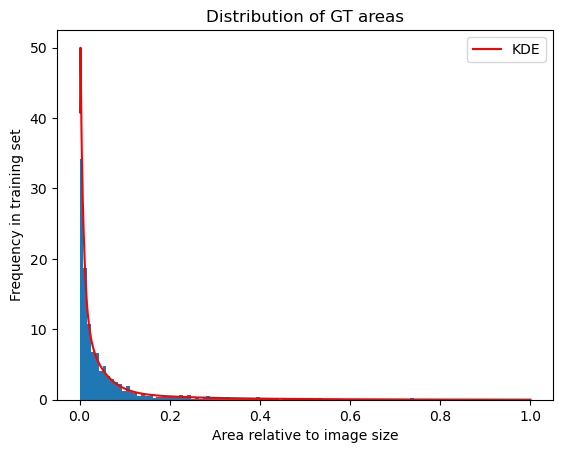

In [101]:
plt.hist(GT_areas, bins=100, density=True)
plt.xlabel('Area relative to image size')
plt.ylabel('Frequency in training set')
plt.title('Distribution of GT areas')

xs = np.linspace(1e-3, 1, 1000)
log_xs = np.log(xs + epsilon)
density = kde(log_xs) / xs #chain rule adjustment
plt.plot(xs, density, label='KDE', color='r')

plt.legend()

plt.show()

# Understand our EfficientNet alterations

In [69]:
import timm
model = timm.create_model('efficientnet_b5', pretrained=True, num_classes=1)

In [70]:
#list model layers and parameter shapes
for name, param in model.named_parameters():
    print(name, param.shape, param.requires_grad)

conv_stem.weight torch.Size([48, 3, 3, 3]) True
bn1.weight torch.Size([48]) True
bn1.bias torch.Size([48]) True
blocks.0.0.conv_dw.weight torch.Size([48, 1, 3, 3]) True
blocks.0.0.bn1.weight torch.Size([48]) True
blocks.0.0.bn1.bias torch.Size([48]) True
blocks.0.0.se.conv_reduce.weight torch.Size([12, 48, 1, 1]) True
blocks.0.0.se.conv_reduce.bias torch.Size([12]) True
blocks.0.0.se.conv_expand.weight torch.Size([48, 12, 1, 1]) True
blocks.0.0.se.conv_expand.bias torch.Size([48]) True
blocks.0.0.conv_pw.weight torch.Size([24, 48, 1, 1]) True
blocks.0.0.bn2.weight torch.Size([24]) True
blocks.0.0.bn2.bias torch.Size([24]) True
blocks.0.1.conv_dw.weight torch.Size([24, 1, 3, 3]) True
blocks.0.1.bn1.weight torch.Size([24]) True
blocks.0.1.bn1.bias torch.Size([24]) True
blocks.0.1.se.conv_reduce.weight torch.Size([6, 24, 1, 1]) True
blocks.0.1.se.conv_reduce.bias torch.Size([6]) True
blocks.0.1.se.conv_expand.weight torch.Size([24, 6, 1, 1]) True
blocks.0.1.se.conv_expand.bias torch.Size(

In [3]:
#just to verify that forward_features takes x all the way through the network, and returns the output of the last layer before the classification head
import inspect
source_code = inspect.getsource(model.forward_features)
print(source_code)

    def forward_features(self, x):
        x = self.conv_stem(x)
        x = self.bn1(x)
        if self.grad_checkpointing and not torch.jit.is_scripting():
            x = checkpoint_seq(self.blocks, x, flatten=True)
        else:
            x = self.blocks(x)
        x = self.conv_head(x)
        x = self.bn2(x)
        return x



In [4]:
# see what regular forward does
print(inspect.getsource(model.forward))

print()

print(inspect.getsource(model.forward_head))




    def forward(self, x):
        x = self.forward_features(x)
        x = self.forward_head(x)
        return x


    def forward_head(self, x, pre_logits: bool = False):
        x = self.global_pool(x)
        if self.drop_rate > 0.:
            x = F.dropout(x, p=self.drop_rate, training=self.training)
        return x if pre_logits else self.classifier(x)



In [5]:
import torch
input = torch.randn(1, 3, 224, 224)


print(model.global_pool(input))

print(input.mean([2, 3]))

tensor([[-0.0003, -0.0023,  0.0051]])
tensor([[-0.0003, -0.0023,  0.0051]])


In [6]:
features = model.forward_features(input)
print(features.shape)
model.classifier.in_features

torch.Size([1, 2048, 7, 7])


2048

In [7]:
from module.models.efficientnet import EfficientNetWithBBox

model2 = EfficientNetWithBBox('efficientnet_b5', pretrained=True, num_classes=1)

In [8]:
model2(input)

(tensor([[0.1723]], grad_fn=<AddmmBackward0>),
 tensor([[-0.1701, -0.0488, -0.1338,  0.2517]], grad_fn=<AddmmBackward0>))

# Run trained model

In [34]:
from module.models.efficientnet import EfficientNetWithBBox
import torch
import matplotlib.pyplot as plt
import os
import json
import random
from utils import parse_xml, compute_t, alter_box
from PIL import Image
import numpy as np

In [35]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
model_path = "Trained_models/model_20241110_1518.pth"
model = EfficientNetWithBBox('efficientnet_b5', pretrained=False, num_classes=1)
model.load_state_dict(torch.load(model_path, map_location=device))

/var/folders/qd/8flc351506n6h1qrb8zdgbl40000gn/T/ipykernel_61583/473102869.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, m

<All keys matched successfully>

In [36]:
# small data loader to avoid memory issues

names = [f"img-{i}" for i in range(1, 11)]

def load_data(names):
    for name in names:
        
        image = Image.open(os.path.join('Potholes', 'annotated-images', name + '.jpg'))
        
        with open(os.path.join('Potholes', 'annotated-images', name + '.xml')) as f:
            GT_boxes = parse_xml(f)
        
        # read proposals
        with open(os.path.join('Potholes', 'annotated-images', name + '_ss.json')) as f:
            SS_boxes = json.load(f)
            SS_boxes = [box['bbox'] for box in SS_boxes]    
        
        yield image, GT_boxes, SS_boxes

In [ ]:
gen = load_data(names)

In [61]:
image, GT_boxes, SS_boxes = next(gen)

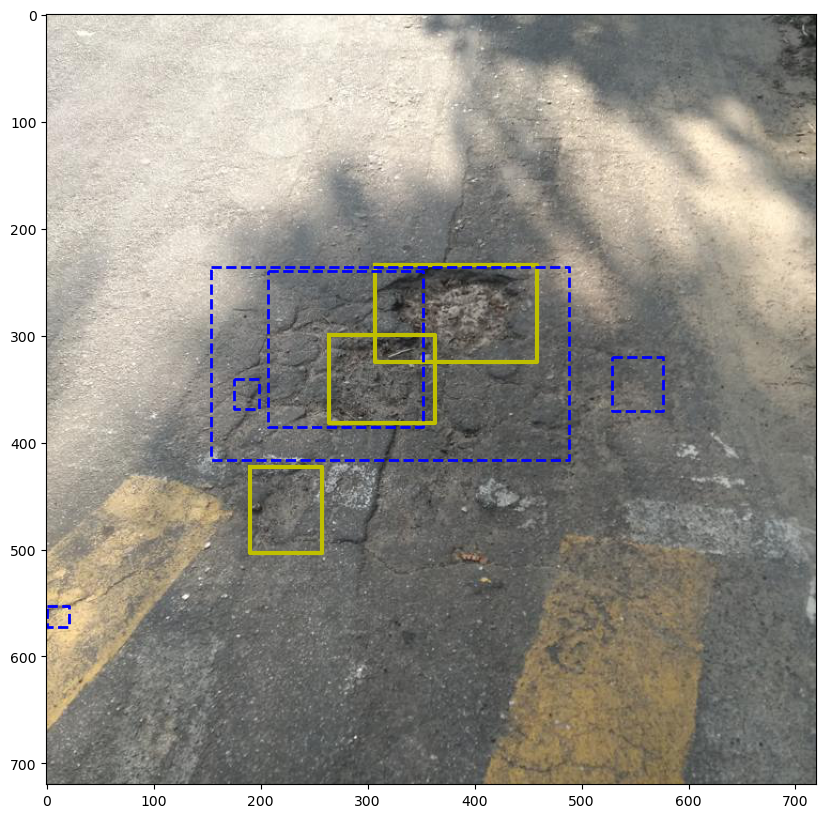

In [62]:
#show image
plt.figure(figsize=(10, 10))
plt.imshow(image)

# Plot GT boxes
for box in GT_boxes:
    plt.plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], 'y', linewidth=3, label='GT')
    
# Plot SS boxes
for box in random.sample(SS_boxes, 5):
    plt.plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], 'b--', linewidth=2, label='SS')

In [63]:
def plot_box(box, **plot_args):
    plt.plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], **plot_args)

Probability of pothole: 0.9999631643295288
t values: [0.0017381012439727783, 0.018958680331707, 0.02301792800426483, 0.026973746716976166]
Probability of pothole: 0.5758852362632751
t values: [-0.05328141897916794, 0.006274791434407234, 0.039765506982803345, -0.011958986520767212]
Probability of pothole: 0.999626636505127
t values: [0.003679569810628891, 0.011090032756328583, 0.027676846832036972, 0.03632098808884621]
Probability of pothole: 2.4094773834804073e-05
t values: [-0.12414335459470749, -0.16192814707756042, -0.12139721214771271, -0.17787516117095947]
Probability of pothole: 1.8221511709271e-05
t values: [0.08778777718544006, 0.041494034230709076, -0.006478391587734222, 0.08414682000875473]
Probability of pothole: 2.776408337012981e-06
t values: [0.09570904076099396, 0.1531529724597931, 0.04322736710309982, -0.300017386674881]
Probability of pothole: 8.100671402644366e-05
t values: [-0.043918393552303314, -0.10522009432315826, 0.22483882308006287, 0.003800461068749428]
Probab

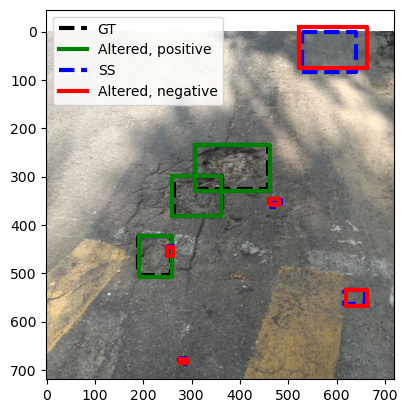

In [64]:
dim = (128, 128)

plt.imshow(image)

GT_boxes_and_some_proposals = [(box, 'GT') for box in GT_boxes] + [(box, 'SS') for box in random.sample(SS_boxes, 5)]

for box, type in GT_boxes_and_some_proposals:
    color = 'b' if type == 'SS' else 'k'
    plot_box(box, color = color, linewidth=3, label=type, linestyle = '--')
    
    crop = image.crop(box)
    resized_crop = crop.resize(dim, Image.LANCZOS)
    tensor_crop = torch.tensor(np.array(resized_crop), dtype=torch.float32).permute(2, 0, 1) / 255.0 
    tensor_crop = tensor_crop.unsqueeze(0).to(device)
    
    class_prob_logit, t_values = model(tensor_crop)
    
    class_prob = torch.sigmoid(class_prob_logit)
    t_values = t_values.squeeze().tolist()
    
    print(f'Probability of pothole: {class_prob.item()}')
    print(f't values: {t_values}')

    # Alter the box
    altered_box = alter_box(box, t_values)
    color = 'g' if class_prob > 0.5 else 'r'
    label = f'Altered, {"positive" if class_prob > 0.5 else "negative"}'
    plot_box(altered_box, color = color, linewidth=3, label=label)

# Remove duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
    
plt.show()

# Implement AP

In [47]:
from utils import calculate_iou
import numpy as np
def AP(gt_boxes, proposed_boxes, proposed_box_probs, threshold=0.5):
    #gt_boxes: Actual positive class boxes in [xmin, ymin, xmax, ymax] format
    #proposed_boxes: All proposed boxes, in [xmin, ymin, xmax, ymax] format
    #proposed_box_probs: Probability of each proposed box being positive class
    #threshold: IOU threshold for a correct detection
    
    # Sort proposed boxes by probability
    order = np.argsort(proposed_box_probs)[::-1]
    proposed_boxes = np.array(proposed_boxes)[order]
    proposed_box_probs = np.array(proposed_box_probs)[order]
    
    # Use IoU to determine if a box is a true positive
    ious = np.array([[calculate_iou(gt_box, proposed_box) for gt_box in gt_boxes] for proposed_box in proposed_boxes])
    max_ious = ious.max(axis=1)
    matches_gt_box = max_ious > threshold
    
    # Calculate precision and recall
    TP = np.cumsum(matches_gt_box)
    FP = np.cumsum(~matches_gt_box)
    
    precision = TP / (TP + FP)
    recall = TP / len(gt_boxes)
    
    # Calculate AP
    AP = np.sum(precision * np.diff([0, *recall]))
    
    return AP
    

In [49]:
true_boxes = np.array([[0, 0, 100, 100], [10, 15, 15, 20]])
proposed_boxes = np.array([[0, 0, 100, 100], [30, 30, 40, 40]])
proposed_box_probs = np.array([0.9, 0.8])

AP(true_boxes, proposed_boxes, proposed_box_probs)

0.5

In [72]:
def AP(Y_batch_pred, Y_batch):
    #Y_batch_pred: Predicted probabilities of pothole presence
    #Y_batch: True labels
    
    # Sort by predicted probability, desacending
    sorted_indices = np.argsort(Y_batch_pred)[::-1]
    
    # Sort labels in that order
    Y_batch = Y_batch[sorted_indices]
    
    # Calculate precision and recall
    TP = np.cumsum(Y_batch)
    FP = np.cumsum(1 - Y_batch)
    
    precision = TP / (TP + FP)
    recall = TP / TP[-1]
    
    print(precision)
    print(recall)
    print(np.diff([0, *recall]))
    
    # Calculate AP
    AP = np.sum(precision * np.diff([0, *recall]))
    
    return AP

AP(np.array([0.95, 0.55, 0.65, 0.71]), np.array([1,1, 1, 0]))


[1.         0.5        0.66666667 0.75      ]
[0.33333333 0.33333333 0.66666667 1.        ]
[0.33333333 0.         0.33333333 0.33333333]


0.8055555555555556

# Experiment with pure bbox regression

Number of positive examples in batch: 17
Loss: 15.697912216186523
Mean IOU: 0.14872132038801122
Loss: 565.2977294921875
Mean IOU: 0.0
Loss: 39.019412994384766
Mean IOU: 0.0016950066847674923
Loss: 129.8232421875
Mean IOU: 0.0014396015855952713
Loss: 317.69793701171875
Mean IOU: 0.0
Loss: 203.29708862304688
Mean IOU: 0.0
Loss: 33.553653717041016
Mean IOU: 0.106920325193731
Loss: 15.743163108825684
Mean IOU: 0.09760406009623834
Loss: 115.63517761230469
Mean IOU: 0.0
Loss: 163.99058532714844
Mean IOU: 0.0
Loss: 107.09736633300781
Mean IOU: 0.0
Loss: 26.005189895629883
Mean IOU: 0.04371525372331165
Loss: 5.338067531585693
Mean IOU: 0.2758560008704406
Loss: 47.15135192871094
Mean IOU: 0.01865236538107171
Loss: 85.80477905273438
Mean IOU: 0.004940408735004835
Loss: 74.86088562011719
Mean IOU: 0.019928490003784684
Loss: 32.39704132080078
Mean IOU: 0.11963918220649553
Loss: 5.328519821166992
Mean IOU: 0.32300294183920814
Loss: 14.771810531616211
Mean IOU: 0.10490069531991825
Loss: 39.472835540

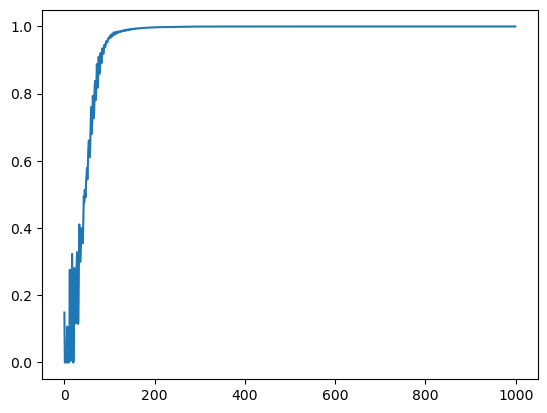

In [45]:
from module.dataloaders.loader import Dataloader
from module.models.efficientnet import EfficientNetWithBBox
from utils import alter_box, calculate_iou
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

data_loader = Dataloader(train = 'val')

model = EfficientNetWithBBox('efficientnet_b1', pretrained=True, num_classes=1)
model.eval()

feature_map = model.model.forward_features
global_pool = model.model.global_pool
classifier = model.model.classifier
bbox_regressor = model.bbox_regressor

i = 0

my_regressor = nn.Linear(classifier.in_features, 4)
my_regressor.train()


loss_fun = nn.MSELoss(reduction='sum') #sum because batches are of different sizes
optimizer = torch.optim.Adam(my_regressor.parameters(), lr = 0.01)


#get a single batch
X_batch, Y_batch, bbox_batch, gt_bbox_batch, tvals_batch = next(iter(data_loader))

#extract only positive examples
X_batch = X_batch[Y_batch == 1]
bbox_batch = bbox_batch[Y_batch == 1]
gt_bbox_batch = gt_bbox_batch[Y_batch == 1]
tvals_batch = tvals_batch[Y_batch == 1].float()
Y_batch = Y_batch[Y_batch == 1]
print(f'Number of positive examples in batch: {len(Y_batch)}')
                            
#step through model
with torch.no_grad():
    features = feature_map(X_batch)
    pooled_features = global_pool(features)

mean_ious = []
for _ in range(1000):
    tvals_pred = my_regressor(pooled_features)
    loss = loss_fun(tvals_pred, tvals_batch)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    adjusted_bbox_batch = [alter_box(bbox, tvals) for bbox, tvals in zip(bbox_batch.detach().numpy(), tvals_pred.detach().numpy())]
    ious = [calculate_iou(gt_bbox, adjusted_bbox) for gt_bbox, adjusted_bbox in zip(gt_bbox_batch.detach().numpy(), adjusted_bbox_batch)]
    
    print(f'Loss: {loss.item()}')
    print(f'Mean IOU: {np.mean(ious)}')
    
    mean_ious.append(np.mean(ious))
    
plt.plot(mean_ious)
    



Okay, regression *is* possible. Here we're clearly overfitting to a tiny batch and training just the regressor.

# Investigate why AP wasn't working

In [66]:
from module.dataloaders.loader import Dataloader
from utils import get_input_size, alter_box, calculate_iou
import numpy as np
model_name = 'efficientnet_b0'

import torch
from module.models.efficientnet import EfficientNetWithBBox  # Replace with your actual model class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model =  EfficientNetWithBBox(model_name=model_name, num_classes=1, bbox_output_size=4, pretrained=True)  # Replace with your model initialization
model = model.to(device)

# Load the saved state dictionary
#checkpoint_path = "Trained_models/model_20241110_1518.pth"
#model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Set the model to evaluation mode (important for inference)
model.eval()

#Load test data (batch size 8 to save memory)
input_size = get_input_size(model_name)
test_loader = Dataloader(train="test", dim=[input_size, input_size], batch_size=8)

def AP(gt_boxes, proposed_boxes, proposed_box_probs, threshold=0.5):
    #gt_boxes: Actual positive class boxes in [xmin, ymin, xmax, ymax] format
    #proposed_boxes: All proposed boxes, in [xmin, ymin, xmax, ymax] format
    #proposed_box_probs: Probability of each proposed box being positive class
    #threshold: IOU threshold for a correct detection
    
    
    
    # Sort proposed boxes by probability
    order = np.argsort(proposed_box_probs)[::-1]
    proposed_boxes = np.array(proposed_boxes)[order].squeeze()
    proposed_box_probs = np.array(proposed_box_probs)[order]
    

    # Use IoU to determine if a box is a true positive
    ious = np.array([[calculate_iou(gt_box, proposed_box) for gt_box in gt_boxes] for proposed_box in proposed_boxes])
    max_ious = ious.max(axis=1)
    matches_gt_box = max_ious > threshold
    
    # Calculate precision and recall
    TP = np.cumsum(matches_gt_box)
    FP = np.cumsum(~matches_gt_box)
    
    precision = TP / (TP + FP)
    recall = TP / len(gt_boxes)
    
    # Calculate AP
    AP = np.sum(precision * np.diff([0, *recall]))
    
    return AP

#Initialize
train_iou = []
train_acc = []

for X_val, Y_val, bbox_val, gt_bbox_val, tvals_val in test_loader:
    # Move data to device
    X_batch = X_val.to(device)
    Y_batch = Y_val.to(device).float()  # Ensure target is float for BCE loss
    gt_bbox = gt_bbox_val.to(device)
    t_batch = tvals_val.to(device)
    bbox = bbox_val.to(device)
    
    # Forward pass
    class_score, t_vals = model(X_batch)
    adjusted_boxes = [alter_box(box, t_val) for box, t_val in zip(bbox.cpu().numpy(), t_vals.detach().cpu().numpy())]

    #_______ Add AP calculations here:____________________
    ap = AP(gt_bbox.cpu().numpy(), adjusted_boxes, class_score.detach().cpu().numpy())
    print(ap)
    #________________________________________________

# Computes average accuracy and iuo across entire test set
avg_train_acc = sum(train_acc)/len(train_acc) 
avg_train_iou = sum(train_iou)/len(train_iou)


print(f"Average test Accuracy: {avg_train_acc * 100:.2f}%")
print(f"Average test Iou     : {avg_train_iou :.2f}")

1.0
1.0
1.0
0.0
1.0
1.0
1.0


KeyboardInterrupt: 

# Investigate Alex's plot functions

/var/folders/qd/8flc351506n6h1qrb8zdgbl40000gn/T/ipykernel_24762/736670035.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

(224, 224)


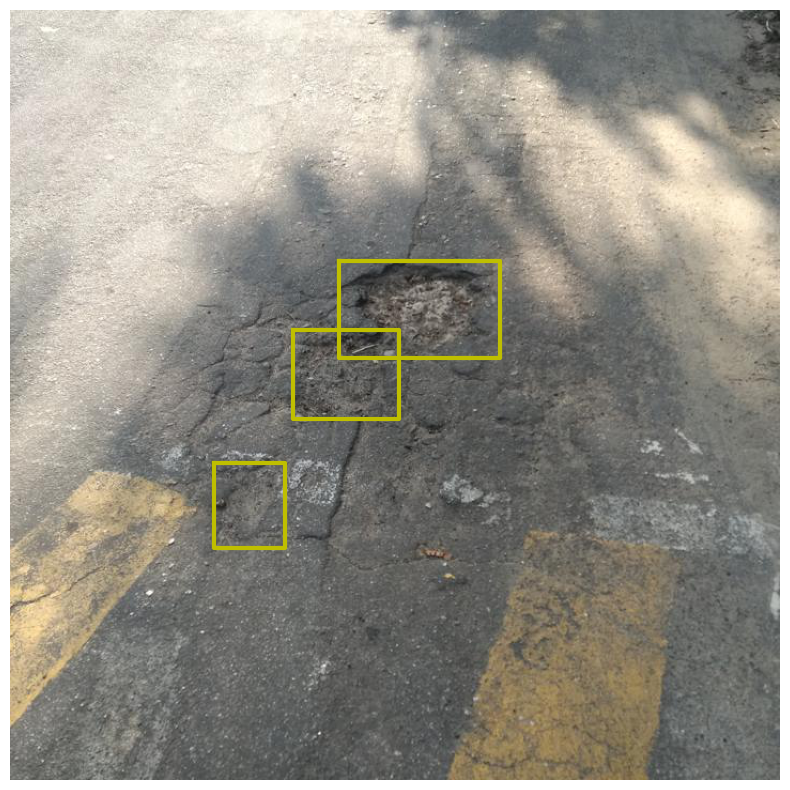

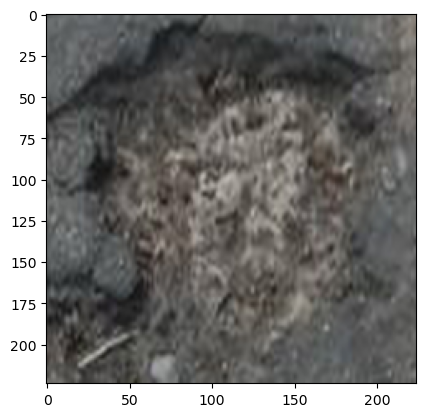

tensor([[0.7483]], grad_fn=<SigmoidBackward0>)


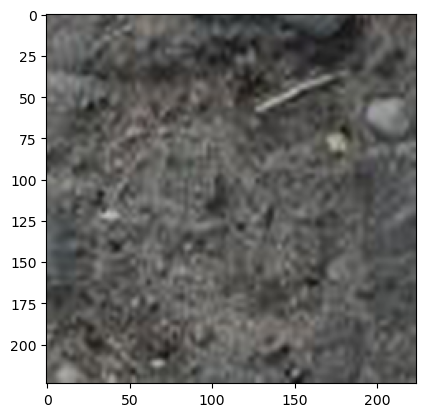

tensor([[0.0990]], grad_fn=<SigmoidBackward0>)


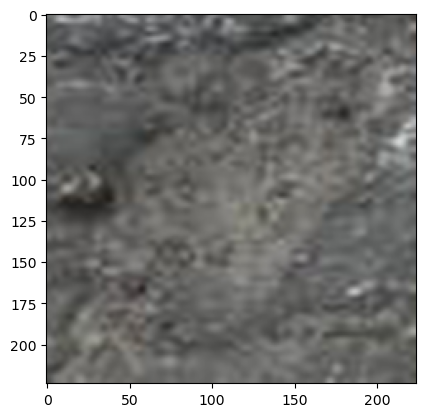

tensor([[0.0774]], grad_fn=<SigmoidBackward0>)


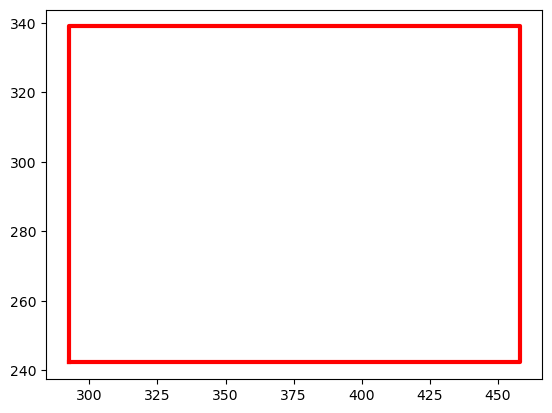

In [15]:
from plots import load_SS_boxes, load_image, load_GT_boxes, plot_image, plot_boxes, plot_altered_NMS_positive
import torch
from PIL import Image
from module.processing.non_maximum_suppression import non_maximum_suppression
from module.models.efficientnet import EfficientNetWithBBox
from utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = 'Trained_models/frederik_good_model.pth'
model_name = 'efficientnet_b0'

path = "graphics/"
image_id = 2
num_class_0 = 5

image = load_image(image_id)
GT_boxes = load_GT_boxes(image_id)

# Load SS boxes with the specified number of GT and class 0 boxes
SS_boxes = load_SS_boxes(image_id, num_GT_boxes=len(GT_boxes), num_class_0=num_class_0)
SS_boxes_all = load_SS_boxes(image_id, num_GT_boxes=len(GT_boxes), num_class_0=num_class_0, all_boxes=True)

# Load the model
model = EfficientNetWithBBox(model_name, pretrained=False, num_classes=1)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

input_size = get_input_size(model_name)
dim = (input_size, input_size)

print(dim)

plot_image(image)
plot_boxes(GT_boxes, color='y', linestyle='-', linewidth=3, label='GT')

discard_threshold = 0.5
consideration_threshold = None

def plot_altered_NMS_positive(image, boxes, model, dim, device, discard_threshold, consideration_threshold, linestyle='-', linewidth=3):
    """Applies NMS to all altered boxes that the model predicts to be potholes and plots results."""    
    boxes_w_probs = []
    
    class_probs = []
    
    for box in boxes:
        model.eval()
        crop = image.crop(box)
        resized_crop = crop.resize(dim, Image.LANCZOS)
        tensor_crop = torch.tensor(np.array(resized_crop), dtype=torch.float32).permute(2, 0, 1) / 255.0 
        tensor_crop = tensor_crop.unsqueeze(0).to(device)  # Ensure tensor_crop is on the same device
        
        plt.figure()
        plt.imshow(tensor_crop.squeeze().permute(1, 2, 0))
        plt.show()
        
        class_prob_logit, t_values = model(tensor_crop)
        
        class_prob = torch.sigmoid(class_prob_logit)
        class_probs.append(class_prob.item())
        t_values = t_values.squeeze().tolist()

        # Alter the box using the t_values
        altered_box = alter_box(box, t_values)
        print(class_prob)
        if class_prob > 0.5:
            boxes_w_probs.append((altered_box, class_prob))

    plt.figure()
    # Apply NMS with chosen thresholds
    nms_boxes = non_maximum_suppression(boxes_w_probs, discard_threshold, consideration_threshold)
    # Plot the resulting boxes after NMS
    for i, (box, class_prob) in enumerate(nms_boxes):
        label = f'Altered, {"positive" if class_prob > 0.5 else "negative"}' if i == 0 else None
        plot_boxes([box], color='r', linestyle=linestyle, linewidth=linewidth, label=label)


plot_altered_NMS_positive(image, GT_boxes, model, dim, device, discard_threshold, consideration_threshold)

# See if I can get positive class probabilities

In [16]:
from utils import *

id = 2
json = read_json("img-"+str(id)+"_ss.json")

path = "Potholes/annotated-images/"
image_name = "img-"+str(id)+".xml"
_, list_with_all_gtboxes = read_content(path+image_name)

list_with_all_gtboxes = [box for box in list_with_all_gtboxes if (box[2]-box[0]) >= 1 and (box[3]-box[1]) >= 1]
class_0, class_1, class_none = split_json_by_class(json)
image_proposals = []
for annotation in class_1:
    bbox = annotation['bbox']
    class_value = annotation['class']

    best_iou = 0
    best_gtbbox = 0
    prop_bbox = bbox
    
    # Loop over all gt bbox in image
    for gtbbox in list_with_all_gtboxes:
        # Computes the iou
        iou = calculate_iou(prop_bbox,gtbbox)
        # Updates best gtbbox
        if iou > best_iou:
            best_iou = iou
            best_gtbbox = gtbbox

    tvals = compute_t(best_gtbbox,prop_bbox)

    proposal = {
        "id": id,
        "bbox" : bbox,
        "gtbbox": best_gtbbox,
        "class" : class_value,
        "t_val" : tvals
    }
    image_proposals.append(proposal)

#loop over gt bbox and add dem as proposals:
for gtbbox in list_with_all_gtboxes:
    proposal = {
        "id": id,
        "bbox" : gtbbox,
        "gtbbox": gtbbox,
        "class" : 1,
        "t_val" : [0,0,0,0]
    }
    image_proposals.append(proposal)

print(image_proposals)
        
image = Image.open(path+"img-"+str(id)+".jpg")

X_batch = []
for proposal in image_proposals:
    bbox = proposal['bbox']
    crop = image.crop(bbox)
    resized_crop = crop.resize(dim, Image.LANCZOS)
    

    #Trun rezised crop into tensor and normalize values
    tensor_crop = torch.tensor(np.array(resized_crop), dtype=torch.float32).permute(2, 0, 1) / 255.0
            
    X_batch.append(tensor_crop)
    
X_batch = torch.stack(X_batch)


[{'id': 2, 'bbox': [272, 315, 352, 378], 'gtbbox': [264, 299, 363, 382], 'class': 1, 't_val': (-0.1, -0.25396825396825395, 0.21309321546070836, 0.27570588140506525)}, {'id': 2, 'bbox': [288, 240, 454, 337], 'gtbbox': [307, 234, 458, 325], 'class': 1, 't_val': (0.1144578313253012, -0.061855670103092786, -0.09470795154161891, -0.06385147198653278)}, {'id': 2, 'bbox': [197, 432, 255, 482], 'gtbbox': [190, 423, 257, 503], 'class': 1, 't_val': (-0.1206896551724138, -0.18, 0.1442496088445467, 0.47000362924573563)}, {'id': 2, 'bbox': [326, 240, 454, 329], 'gtbbox': [307, 234, 458, 325], 'class': 1, 't_val': (-0.1484375, -0.06741573033707865, 0.16524957289530717, 0.022223136784710256)}, {'id': 2, 'bbox': [304, 236, 488, 349], 'gtbbox': [307, 234, 458, 325], 'class': 1, 't_val': (0.016304347826086956, -0.017699115044247787, -0.1976559207940613, -0.21652831219549049)}, {'id': 2, 'bbox': [253, 315, 352, 385], 'gtbbox': [264, 299, 363, 382], 'class': 1, 't_val': (0.1111111111111111, -0.22857142857

In [17]:
X_batch = X_batch.to(device)
class_score_logits, t_vals = model(X_batch[:7])
class_scores = torch.sigmoid(class_score_logits)

In [18]:
print(class_scores.max())

tensor(0.8022, grad_fn=<MaxBackward1>)


# Testloader, leading up to calculating AP

/var/folders/qd/8flc351506n6h1qrb8zdgbl40000gn/T/ipykernel_80007/2762229803.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

1
torch.Size([10, 3, 128, 128])
torch.Size([10, 4])
torch.Size([10, 1])
torch.Size([10])
torch.Size([2, 3, 128, 128])
2
2
torch.Size([10, 3, 128, 128])
torch.Size([10, 4])
torch.Size([10, 1])
torch.Size([10])
torch.Size([1, 3, 128, 128])
1
3
torch.Size([10, 3, 128, 128])
torch.Size([10, 4])
torch.Size([10, 1])
torch.Size([10])
torch.Size([1, 3, 128, 128])
1
4
torch.Size([10, 3, 128, 128])
torch.Size([10, 4])
torch.Size([10, 1])
torch.Size([10])
torch.Size([2, 3, 128, 128])
2
5


0.20833333333333331

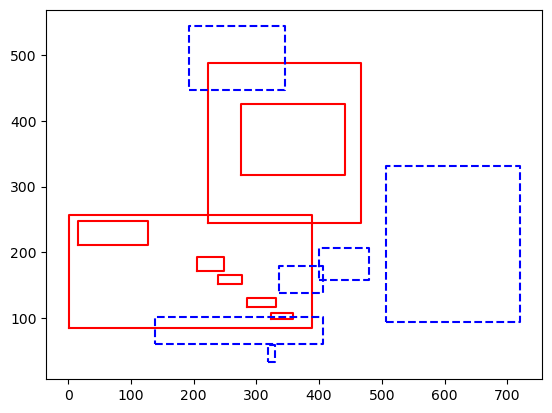

In [46]:
#plot gt boxes
import matplotlib.pyplot as plt
for box in all_gt_bboxs:
    xmin, ymin, xmax, ymax = box
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color='r')
    
for box in all_positive_proposal_bboxs:
    xmin, ymin, xmax, ymax = box
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color='b', linestyle='--')

# Plot AP graph

/Users/andreas/anaconda3/envs/DLinCV/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


0.4692377136716824


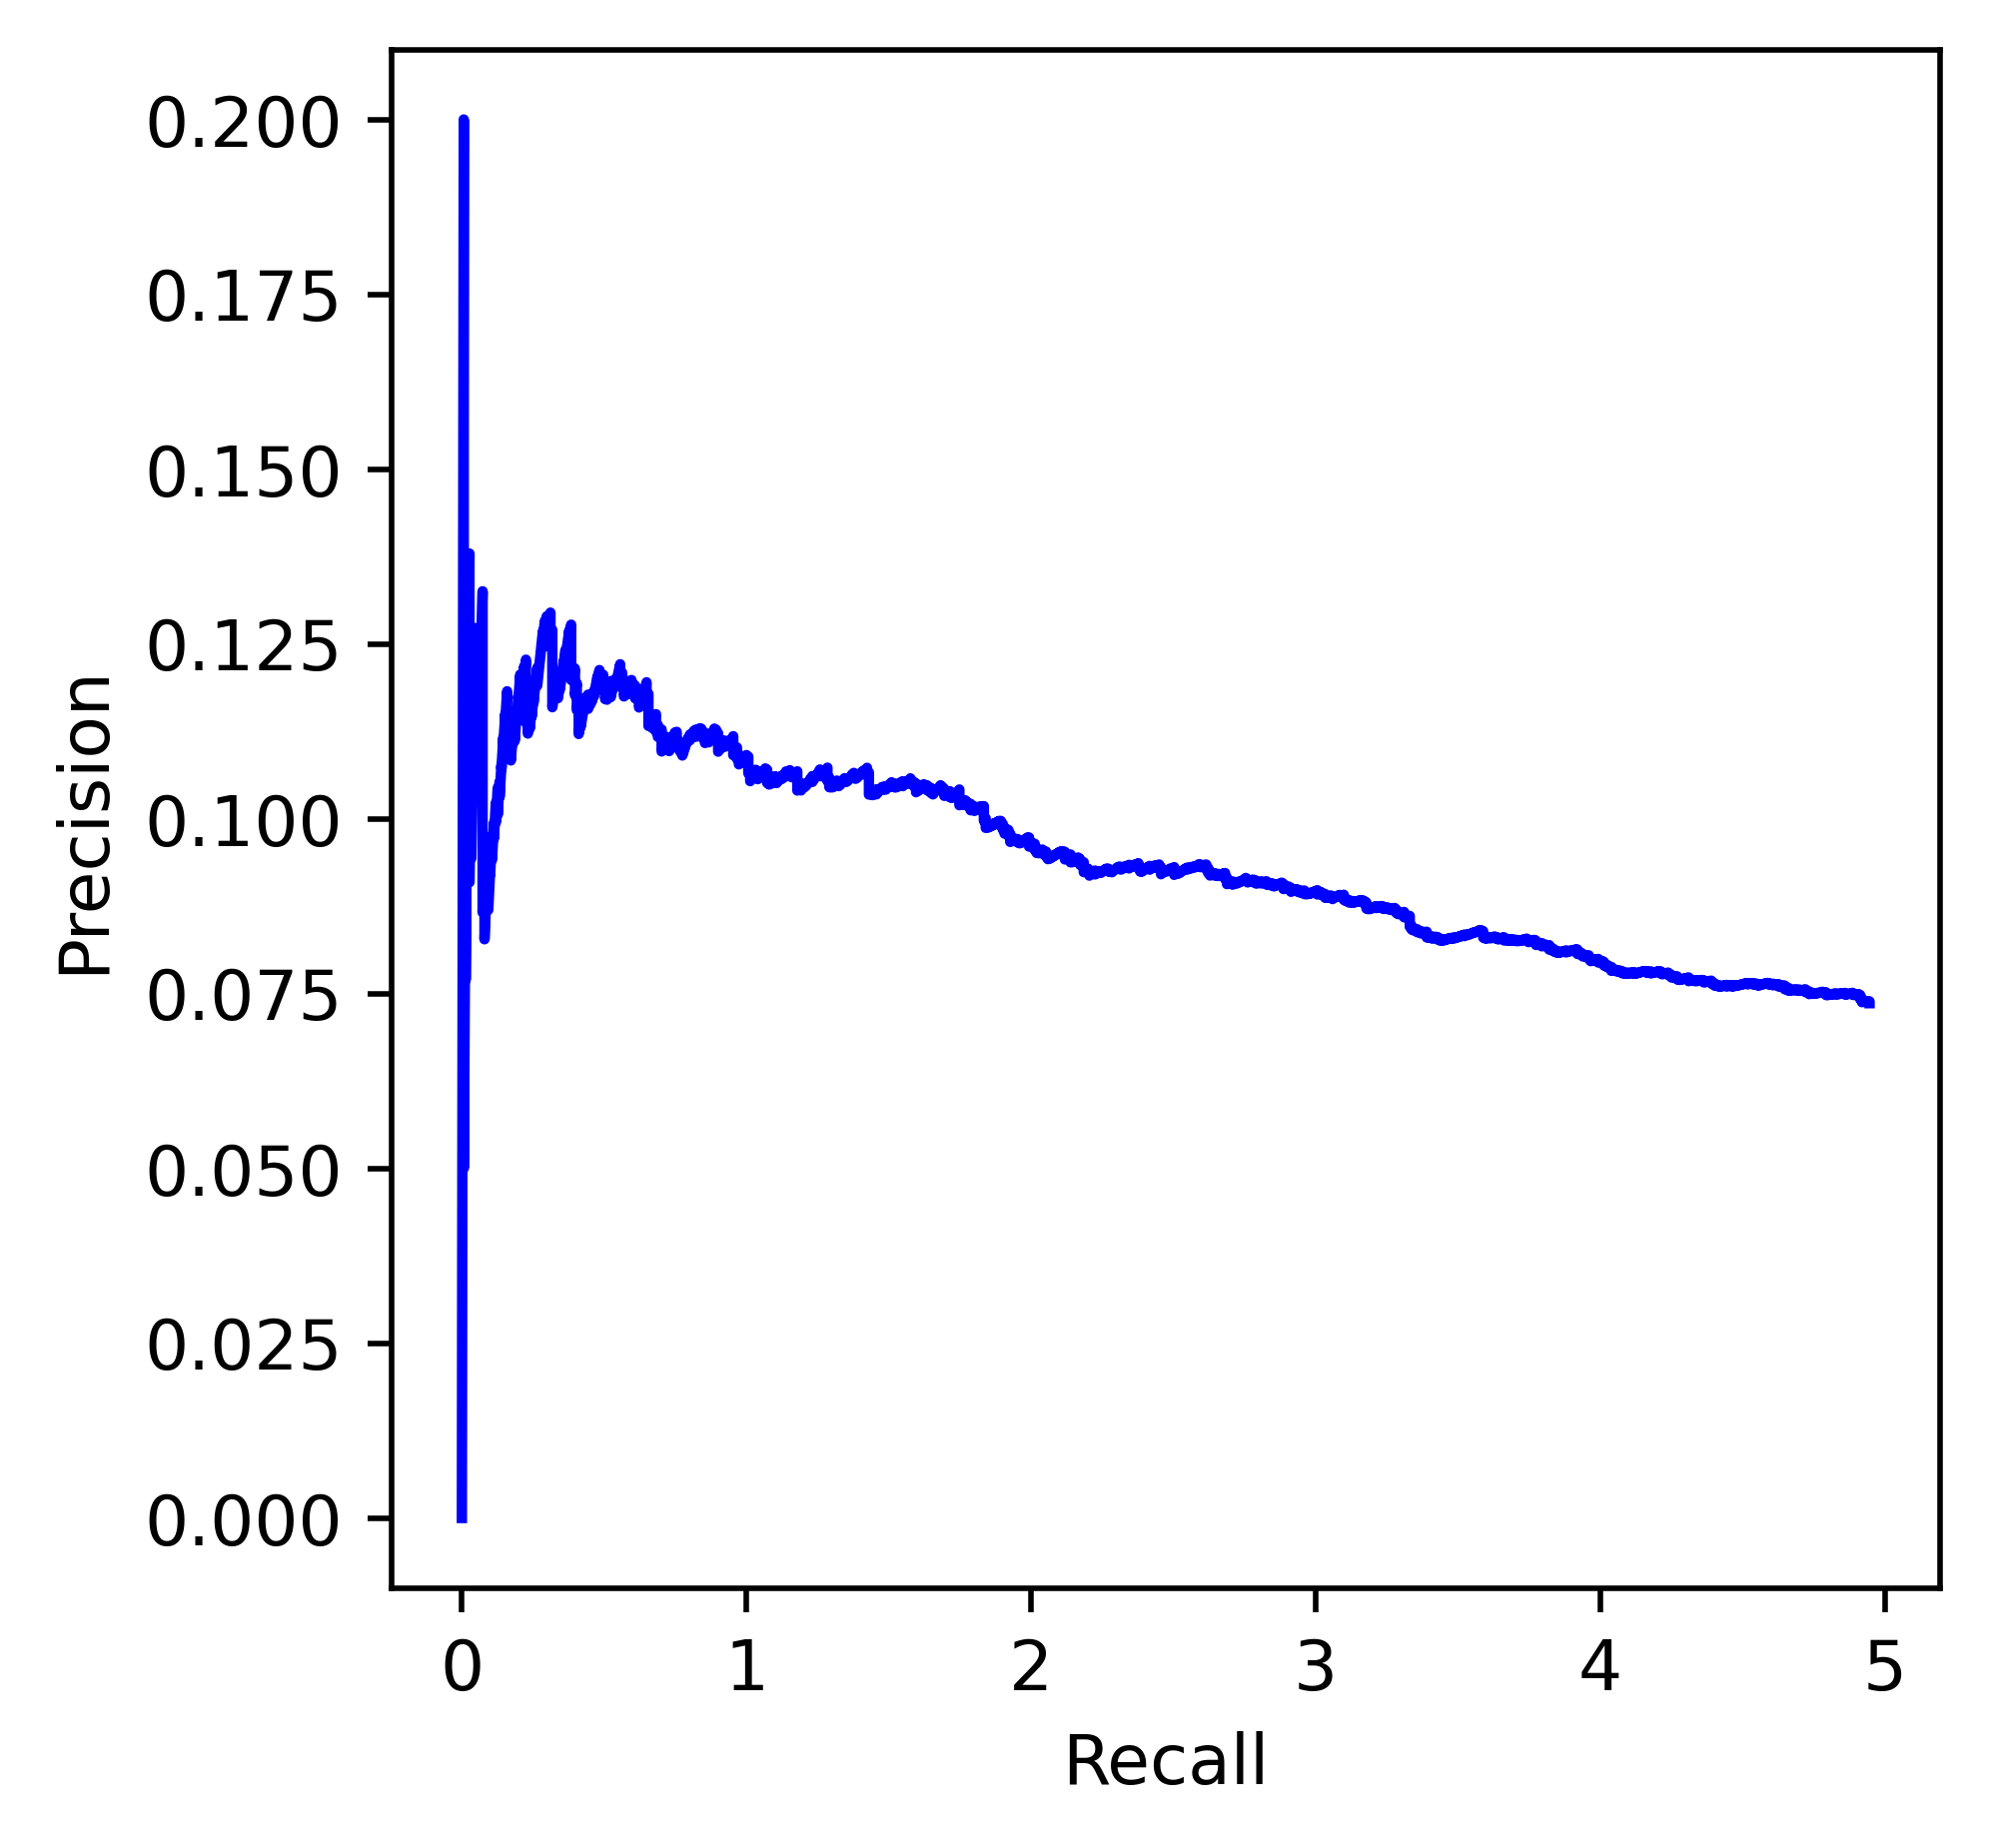

In [5]:
import pickle
import matplotlib.pyplot as plt
from module.metrics.AP import AP

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=500, facecolor='none', edgecolor='none')

with open('dumps/ap_input_20241116_2026.pkl', 'rb') as f:
    all_gt_bboxs, all_positive_proposal_bboxs, all_positive_proposals_probs = pickle.load(f)
    
    
ap, precision, recall = AP(all_gt_bboxs, all_positive_proposal_bboxs, all_positive_proposals_probs, return_precision_recall=True)


plt.plot(recall, precision, label=f'AP: {ap:.2f}', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')

print(ap)



In [6]:
len(all_gt_bboxs)

151

In [7]:
len(all_positive_proposal_bboxs)

10147